In [1]:
import os

dataset_path = "/kaggle/input/good-dataset-0-1/good_dataset_0_1"
train_images_path = os.path.join(dataset_path, "images/train")
train_masks_path = os.path.join(dataset_path, "annotations/train")
test_images_path = os.path.join(dataset_path, "images/test")
test_masks_path = os.path.join(dataset_path, "annotations/test")

print("Train Images:", len(os.listdir(train_images_path)))
print("Train Masks:", len(os.listdir(train_masks_path)))
print("Test Images:", len(os.listdir(test_images_path)))
print("Test Masks:", len(os.listdir(test_masks_path)))

print("\nПримеры файлов (Train Images):", os.listdir(train_images_path)[:5])
print("Примеры файлов (Train Masks):", os.listdir(train_masks_path)[:5])


Train Images: 1117
Train Masks: 1117
Test Images: 277
Test Masks: 277

Примеры файлов (Train Images): ['000_png.rf.8fe3d8306d8a507b7df05140dd6f9604.jpg', '00414_jpg.rf.9f69c82751ba6fbec2ec771f0558f395.jpg', '00433_jpg.rf.79ad3d25676ada41e910e4be41dc4a63.jpg', '00530_jpg.rf.65d6515f70a46d74f66144a9d79e2c89.jpg', '00426_jpg.rf.08c9ebaa5de29d14464de96ff52898c8.jpg']
Примеры файлов (Train Masks): ['g1-1095-_JPG_jpg.rf.eb9280393abb57e561966f9ca4fcd787.png', 'anthracnose_fruit_rot39_jpg.rf.1056ac5ea8ea52ef83c9943a55b1800a.png', '00586_jpg.rf.059fc29eec33e0e0137c3a472faad54e.png', '00164_jpg.rf.d4b8011d9f7379a34a8034197a4c3830.png', 'anthracnose_fruit_rot72_jpg.rf.35c2ca2c07f6860604398792a61bebde.png']


✅ Изображение: (234, 326, 3), Маска: (234, 326), dtype: uint8


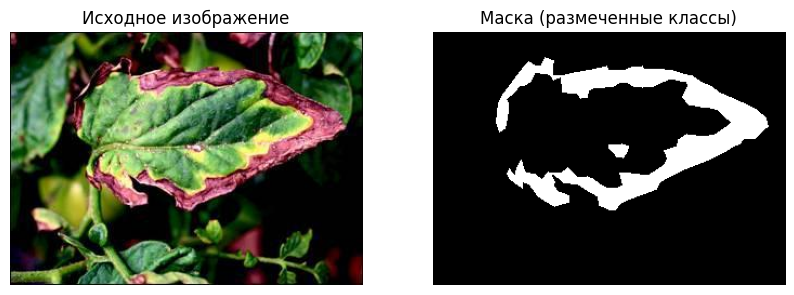

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# Функция для загрузки и отображения изображения и маски
def visualize_sample(image_path, mask_path):
    if not os.path.exists(image_path):
        print(f"❌ Изображение не найдено: {image_path}")
        return
    if not os.path.exists(mask_path):
        print(f"❌ Маска не найдена: {mask_path}")
        return
    
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = Image.open(mask_path).convert("L")
    mask = np.array(mask)

    
    print(f"✅ Изображение: {image.shape}, Маска: {mask.shape}, dtype: {mask.dtype}")

    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title("Исходное изображение")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Маска (размеченные классы)")
    ax[1].axis("off")

    plt.show()


image_files = sorted(os.listdir(train_images_path))
mask_files = sorted(os.listdir(train_masks_path))


sample_image = image_files[0]


sample_mask = os.path.splitext(sample_image)[0] + ".png"


image_path = os.path.join(train_images_path, sample_image)
mask_path = os.path.join(train_masks_path, sample_mask)


visualize_sample(image_path, mask_path)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# Dataset для сегментации с ресайзом
class PlantSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, img_size=512):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        mask_filename = os.path.splitext(image_filename)[0] + ".png"
        image_path = os.path.join(self.images_dir, image_filename)
        mask_path = os.path.join(self.masks_dir, mask_filename)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (self.img_size, self.img_size))  # Ресайз до 512x512
        image = image.astype(np.float32) / 255.0  # Нормализация [0,1]

        #копируем одно и то же изображение в 3 канала)
        image = np.stack([image, image, image], axis=-1)  # [H, W, 3]

        mask = Image.open(mask_path).convert("L")
        mask = mask.resize((self.img_size, self.img_size), Image.NEAREST)  # Ресайз маски (NEAREST для классов)
        mask = np.array(mask, dtype=np.int64)  # Оставляем как int64 (классы)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

#train
train_dataset = PlantSegDataset(train_images_path, train_masks_path, img_size=512)

sample_img, sample_mask = train_dataset[0]
print(f"Форма изображения: {sample_img.shape}")  # [3, 512, 512]
print(f"Форма маски: {sample_mask.shape}")        # [512, 512]
print(f"Классы в маске: {torch.unique(sample_mask)}")  # Проверяем классы


Форма изображения: torch.Size([3, 512, 512])
Форма маски: torch.Size([512, 512])
Классы в маске: tensor([0, 1])


In [4]:
BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

batch_images, batch_masks = next(iter(train_loader))
print(f"Размер batch изображений: {batch_images.shape}")  # [B, 3, 512, 512]
print(f"Размер batch масок: {batch_masks.shape}")        # [B, 512, 512]


Размер batch изображений: torch.Size([8, 3, 512, 512])
Размер batch масок: torch.Size([8, 512, 512])


In [5]:
mask_files = sorted(os.listdir(train_masks_path))[:1]

for mask_file in mask_files:
    mask_path = os.path.join(train_masks_path, mask_file)
    mask = Image.open(mask_path)
    mask_array = np.array(mask)

    print(f"Маска: {mask_file} → Уникальные классы: {np.unique(mask_array)}")

Маска: 00001_jpg.rf.9cf439382a046d16dae98b964c77cb07.png → Уникальные классы: [0 1]


In [7]:
mask_files = sorted(os.listdir(train_masks_path))

all_classes = set()

for mask_file in mask_files:
    mask_path = os.path.join(train_masks_path, mask_file)
    mask = Image.open(mask_path)
    mask_array = np.array(mask)
    
    unique_classes = np.unique(mask_array)
    all_classes.update(unique_classes)

print(f"Общее количество уникальных классов: {len(all_classes)}")
print(f"Уникальные классы: {sorted(all_classes)}")


Общее количество уникальных классов: 2
Уникальные классы: [0, 1]


In [8]:
print(len(all_classes))

2


In [6]:
import torch.nn as nn
import torchvision.models.segmentation as segmentation
from torch.optim import Adam

model = segmentation.deeplabv3_resnet50(pretrained=True)
num_classes = 2  # Включая класс фона
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load("/kaggle/input/deeplabv3-resnet50-plantseg01-finetuned/deeplabv3-resnet50-plantseg01_finetuned.pth"))
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 201MB/s]  
<ipython-input-6-18d388d16cf4>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), 

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [7]:
# Замораживаем все слои модели, кроме классификаторов
for param in model.parameters():
    param.requires_grad = False

# Размораживаем последний блок и классификаторы (включая aux_classifier)
for param in model.classifier.parameters():
    param.requires_grad = True

# Размораживаем aux_classifier
for param in model.aux_classifier.parameters():
    param.requires_grad = True

# Заменяем последний слой на соответствующее количество классов
num_classes = 2  # Включая класс фона
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Обучается: {name}")
    else:
        print(f"Заморожено: {name}")



Заморожено: backbone.conv1.weight
Заморожено: backbone.bn1.weight
Заморожено: backbone.bn1.bias
Заморожено: backbone.layer1.0.conv1.weight
Заморожено: backbone.layer1.0.bn1.weight
Заморожено: backbone.layer1.0.bn1.bias
Заморожено: backbone.layer1.0.conv2.weight
Заморожено: backbone.layer1.0.bn2.weight
Заморожено: backbone.layer1.0.bn2.bias
Заморожено: backbone.layer1.0.conv3.weight
Заморожено: backbone.layer1.0.bn3.weight
Заморожено: backbone.layer1.0.bn3.bias
Заморожено: backbone.layer1.0.downsample.0.weight
Заморожено: backbone.layer1.0.downsample.1.weight
Заморожено: backbone.layer1.0.downsample.1.bias
Заморожено: backbone.layer1.1.conv1.weight
Заморожено: backbone.layer1.1.bn1.weight
Заморожено: backbone.layer1.1.bn1.bias
Заморожено: backbone.layer1.1.conv2.weight
Заморожено: backbone.layer1.1.bn2.weight
Заморожено: backbone.layer1.1.bn2.bias
Заморожено: backbone.layer1.1.conv3.weight
Заморожено: backbone.layer1.1.bn3.weight
Заморожено: backbone.layer1.1.bn3.bias
Заморожено: backbo

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [9]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

classifier.0.convs.0.0.weight разморожен
classifier.0.convs.0.1.weight разморожен
classifier.0.convs.0.1.bias разморожен
classifier.0.convs.1.0.weight разморожен
classifier.0.convs.1.1.weight разморожен
classifier.0.convs.1.1.bias разморожен
classifier.0.convs.2.0.weight разморожен
classifier.0.convs.2.1.weight разморожен
classifier.0.convs.2.1.bias разморожен
classifier.0.convs.3.0.weight разморожен
classifier.0.convs.3.1.weight разморожен
classifier.0.convs.3.1.bias разморожен
classifier.0.convs.4.1.weight разморожен
classifier.0.convs.4.2.weight разморожен
classifier.0.convs.4.2.bias разморожен
classifier.0.project.0.weight разморожен
classifier.0.project.1.weight разморожен
classifier.0.project.1.bias разморожен
classifier.1.weight разморожен
classifier.2.weight разморожен
classifier.2.bias разморожен
classifier.4.weight разморожен
classifier.4.bias разморожен
aux_classifier.0.weight разморожен
aux_classifier.1.weight разморожен
aux_classifier.1.bias разморожен
aux_classifier.4.wei

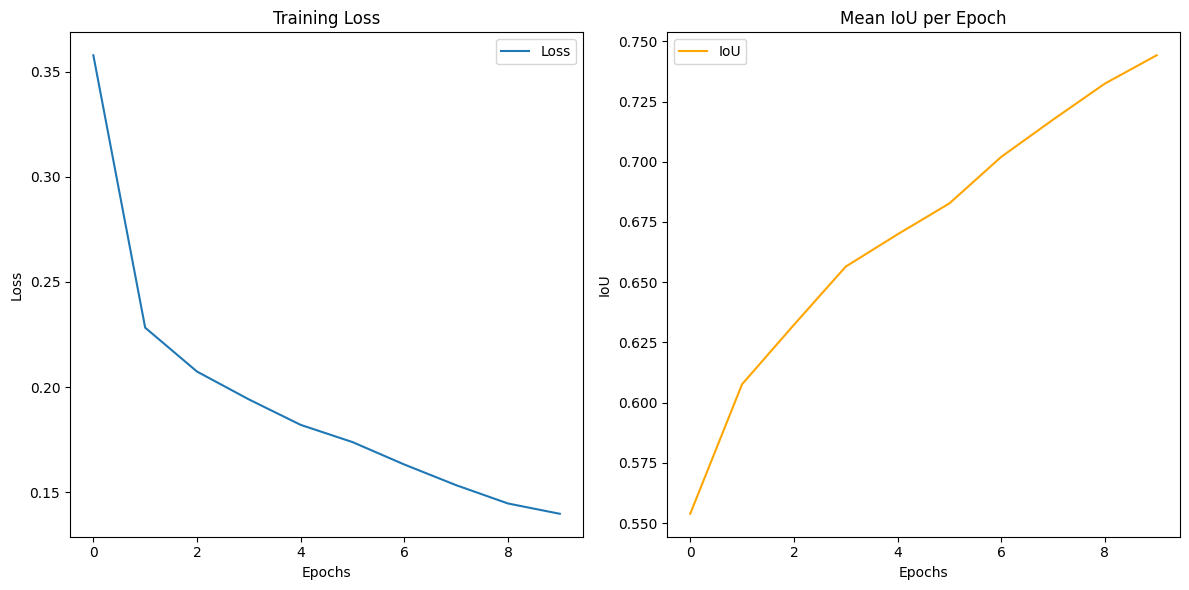

In [10]:
import torchvision
from torchvision import transforms
from sklearn.metrics import confusion_matrix

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} разморожен")

train_dataset = PlantSegDataset(train_images_path, train_masks_path, img_size=512)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()

# Функция для расчета IoU
def calculate_iou(preds, labels, num_classes):
    """
    Функция для расчета IoU для всех классов.
    """
    preds = preds.argmax(dim=1)
    iou_per_class = []
    for i in range(num_classes):
        intersection = ((preds == i) & (labels == i)).sum().item()
        union = ((preds == i) | (labels == i)).sum().item()
        iou = intersection / union if union != 0 else float('nan')
        iou_per_class.append(iou)
    return iou_per_class


epochs = 10
all_losses = []  # Список для хранения потерь
all_ious = []  # Список для хранения IoU на каждой эпохе

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    iou_list = []  # Список для IoU на одной эпохе
    
    for batch_idx, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        output = outputs['out']

        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Вычисляем IoU для текущего батча
        iou_batch = calculate_iou(output, masks, num_classes=2)
        iou_list.append(iou_batch)

        # Выводим потери на каждой 10-й итерации
        if batch_idx % 10 == 0:
            print(f"Эпоха {epoch+1}/{epochs}, Итерация {batch_idx}/{len(train_loader)}, Потери: {running_loss/(batch_idx+1)}")


    avg_loss = running_loss / len(train_loader)
    avg_iou = np.nanmean(iou_list)
    all_losses.append(avg_loss)
    all_ious.append(avg_iou)

    print(f"Эпоха {epoch+1}/{epochs}, Средние потери: {avg_loss:.4f}, Средний IoU: {avg_iou:.4f}")


torch.save(model.state_dict(), "deeplabv3_resnet50-good-dataset-finetuned.pth")


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(range(epochs), all_losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(epochs), all_ious, label='IoU', color='orange')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Mean IoU per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
test_dataset = PlantSegDataset(test_images_path, test_masks_path, img_size=512)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, drop_last=True)

In [14]:
#model.load_state_dict(torch.load("deeplabv3_finetuned.pth"))
#model.to(device)
#model.eval()

predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)

        outputs = model(images)
        preds = outputs['out'].argmax(dim=1)

        predictions.extend(preds.cpu().numpy())

print(f"Получены предсказания для {len(predictions)} изображений.")


Получены предсказания для 276 изображений.


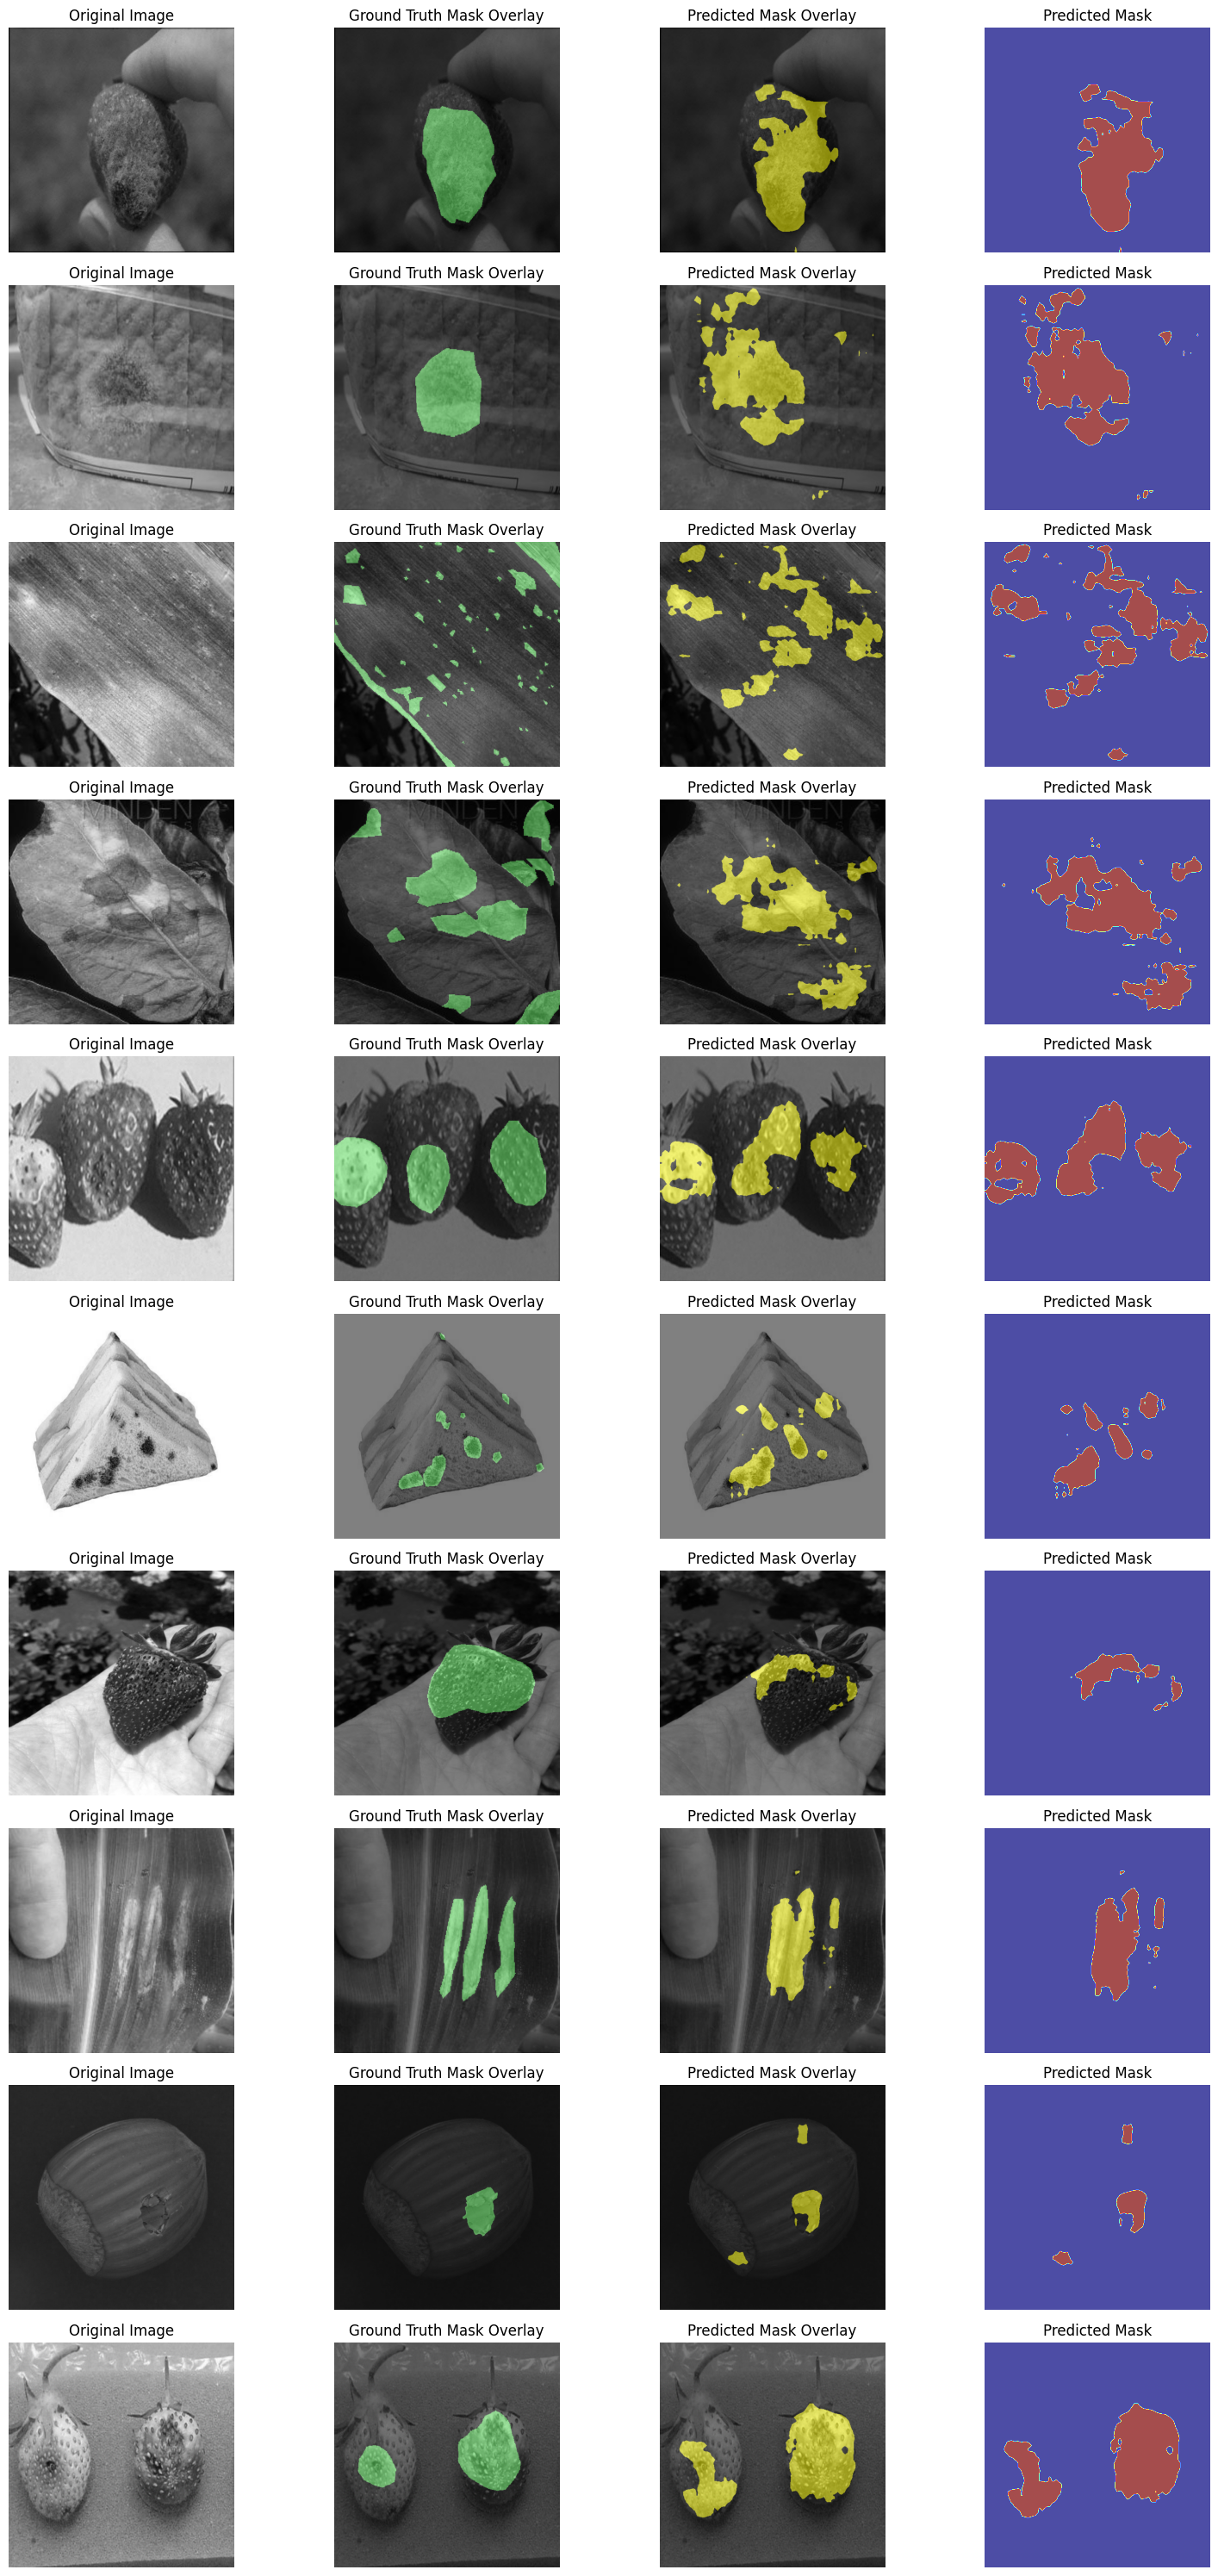

In [31]:
import random

def apply_mask(image, mask, color=(255, 0, 0), alpha=0.5):
    """Накладывает маску на изображение с прозрачностью."""
    colored_mask = np.zeros_like(image)
    for i in range(3):
        colored_mask[:, :, i] = mask * color[i]
    
    overlay = cv2.addWeighted(image, 1 - alpha, colored_mask, alpha, 0)
    return overlay

def visualize_predictions(test_loader, predictions, num_samples=10):
    samples = random.sample(range(len(predictions)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))
    
    for i, idx in enumerate(samples):
        image, mask = test_loader.dataset[idx]
        image = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        mask = mask.cpu().numpy()
        pred_mask = predictions[idx]
        
        overlay_pred = apply_mask((image * 255).astype(np.uint8), pred_mask, color=(255, 255, 0), alpha=0.5)
        
        
        overlay_gt = apply_mask((image * 255).astype(np.uint8), mask, color=(100, 238, 100), alpha=0.5)
        
        axes[i, 0].imshow(image)
        axes[i, 0].set_title("Original Image")
        
        axes[i, 1].imshow(overlay_gt)
        axes[i, 1].set_title("Ground Truth Mask Overlay")
        
        axes[i, 2].imshow(overlay_pred)
        axes[i, 2].set_title("Predicted Mask Overlay")
        
        axes[i, 3].imshow(pred_mask, cmap='jet', alpha=0.7)
        axes[i, 3].set_title("Predicted Mask")
        
        for ax in axes[i]:
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()


visualize_predictions(test_loader, predictions, num_samples=10)


In [15]:

def calculate_iou(preds, labels, num_classes):
    """
    Функция для расчета IoU для всех классов.
    """
    preds = preds.argmax(dim=1)  # Преобразуем [B, C, H, W] -> [B, H, W]
    
    iou_per_class = []
    for i in range(num_classes):
        intersection = ((preds == i) & (labels == i)).sum().item()
        union = ((preds == i) | (labels == i)).sum().item()
        iou = intersection / union if union != 0 else float('nan')
        iou_per_class.append(iou)
        
    return np.nanmean(iou_per_class)  # Усредняем IoU по всем классам

def calculate_accuracy(preds, labels):
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total



model.load_state_dict(torch.load("/kaggle/input/deeplabv3-resnet50-good-dataset-finetuned/deeplabv3_resnet50-good-dataset-finetuned.pth"))
model.to(device)
model.eval()

test_ious = []
test_accuracies = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        
        outputs = model(images)
        output = outputs['out']
        preds = output.argmax(dim=1)
        
        iou_batch = calculate_iou(output, masks, num_classes=117)
        test_ious.append(iou_batch)

      
        acc = calculate_accuracy(preds, masks)
        test_accuracies.append(acc)


mean_iou = np.nanmean(test_ious)
mean_accuracy = np.mean(test_accuracies)

print(f"Средний IoU на тестовой выборке: {mean_iou:.4f}")
print(f"Средняя Accuracy на тестовой выборке: {mean_accuracy:.4f}")


<ipython-input-15-906cfa73689a>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/deeplabv3-resnet50-good-dataset-finetuned/d

Средний IoU на тестовой выборке: 0.6349
Средняя Accuracy на тестовой выборке: 0.9028


In [16]:
def dice_score(preds, masks, num_classes):
    
    preds = preds.cpu().numpy()
    masks = masks.cpu().numpy()

    print(f"preds shape: {preds.shape}, masks shape: {masks.shape}")

    dice_per_class = np.zeros(num_classes)
    
    for i in range(num_classes):
        intersection = np.logical_and(preds == i, masks == i).sum()
        union = (preds == i).sum() + (masks == i).sum()

        if union > 0:
            dice_per_class[i] = (2 * intersection) / union
    
    mean_dice = np.mean(dice_per_class[dice_per_class > 0])
    return dice_per_class, mean_dice

In [17]:
print(f"preds shape: {preds.shape}, masks shape: {masks.shape}")


preds shape: torch.Size([4, 512, 512]), masks shape: torch.Size([4, 512, 512])


In [18]:
preds = model(images)['out'].argmax(dim=1)
batch_dice, mean_dice = dice_score(preds, masks, num_classes)
print(f"Средний Dice Score: {mean_dice:.4f}")


preds shape: (4, 512, 512), masks shape: (4, 512, 512)
Средний Dice Score: 0.7374


In [19]:
from sklearn.metrics import precision_recall_curve, auc

def calculate_map(preds, masks, num_classes):
    ap_per_class = []

    preds = preds.cpu().numpy()
    masks = masks.cpu().numpy()

    for i in range(1, num_classes):  # Пропускаем фон (0)
        y_true = (masks == i).astype(np.uint8).flatten()
        y_pred = (preds == i).astype(np.uint8).flatten()

        if np.sum(y_true) == 0:
            continue

        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        ap = auc(recall, precision)  # Площадь под PR-кривой
        ap_per_class.append(ap)

    return np.mean(ap_per_class) if ap_per_class else 0.0  # Усредняем по классам

preds = outputs['out'].argmax(dim=1)

mean_ap = calculate_map(preds, masks, num_classes=2)
print(f"Средний mAP: {mean_ap:.4f}")



Средний mAP: 0.6013
